# Cel analizy: 
Na podstawie danych pogodowych z dnia i miejsca wylotu, informacji o przewoźniku i samolocie, a także godznie wylotu chcemy oszacować, czy lot będzie opóźniony powyżej 15 minut. Jeśli tak, to o ile minut.

##### Importujemy potrzebne biblioteki oraz plik z ukrytymi danymi do logowania

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
import xgboost as xgb
import joblib

##### Wczytujemy zapisaną wcześniej ramkę danych `flight_df` do zmniennej o takiej samej nazwie

In [2]:
# Ścieżka do pliku CSV
file_path = '../data/processed/flight_df_03.csv'

# Wczytujemy dane z pliku CSV do ramki danych
flight_df = pd.read_csv(file_path)

# Sprawdzenie pierwszych kilku wierszy, aby upewnić się, że dane zostały poprawnie wczytane
flight_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,destination_city_name,date,station,name,prcp,snow,snwd,tmax,awnd,tmax_group
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,"Denver, CO",2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.0,0.0,0.0,53.0,20.36,"(50, 55]"
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,"Denver, CO",2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.0,0.0,0.0,53.0,20.36,"(50, 55]"
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,"Denver, CO",2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.0,0.0,0.0,53.0,20.36,"(50, 55]"
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,"Denver, CO",2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.0,0.0,0.0,53.0,20.36,"(50, 55]"
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,"Fort Lauderdale, FL",2019-01-20,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,0.0,0.0,0.0,53.0,20.36,"(50, 55]"


In [3]:
# Sprawdzamy, jakie kolumny mamy dostępne
flight_df.columns

Index(['id', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
       'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'year', 'is_delayed', 'is_weekend',
       'distance_agg', 'manufacture_year', 'manufacture_year_agg',
       'origin_city_name', 'destination_city_name', 'date', 'station', 'name',
       'prcp', 'snow', 'snwd', 'tmax', 'awnd', 'tmax_group'],
      dtype='object')

In [4]:
flight_df.shape

(1045174, 44)

In [5]:
# Sprawdzamy brakujące wartości w kolumnach
missing_values = flight_df.isnull().sum()
print(missing_values[missing_values > 0])

arr_time                    197
arr_delay_new              1917
actual_elapsed_time        1917
carrier_delay            831110
weather_delay            831110
nas_delay                831110
security_delay           831110
late_aircraft_delay      831110
origin_city_name           5091
destination_city_name      5097
station                    5305
name                       5305
prcp                       5424
snow                     348773
snwd                     410638
tmax                       5435
awnd                       5449
tmax_group                 5435
dtype: int64


In [6]:
# Zostawiamy kolumny, które mają mniej niż 10 000 braków
flight_df = flight_df[flight_df.columns[flight_df.isnull().sum() <= 10000]]

In [7]:
flight_df.shape

(1045174, 37)

In [8]:
# Sprawdzamy brakujące wartości w kolumnach
missing_values = flight_df.isnull().sum()
print(missing_values[missing_values > 0])

arr_time                  197
arr_delay_new            1917
actual_elapsed_time      1917
origin_city_name         5091
destination_city_name    5097
station                  5305
name                     5305
prcp                     5424
tmax                     5435
awnd                     5449
tmax_group               5435
dtype: int64


In [9]:
# Usuwamy wiersze, które mają puste wartości w kolumnie name
flight_df = flight_df.dropna(subset=['name'])

In [10]:
# Sprawdzamy brakujące wartości w kolumnach
missing_values = flight_df.isnull().sum()
print(missing_values[missing_values > 0])

arr_time                  196
arr_delay_new            1915
actual_elapsed_time      1915
destination_city_name    5097
prcp                      119
tmax                      130
awnd                      144
tmax_group                130
dtype: int64


In [11]:
# Usuwamy wiersze, które mają puste wartości w kolumnie destination_city_name
flight_df = flight_df.dropna(subset=['destination_city_name'])

In [12]:
# Sprawdzamy brakujące wartości w kolumnach
missing_values = flight_df.isnull().sum()
print(missing_values[missing_values > 0])

arr_time                196
arr_delay_new          1913
actual_elapsed_time    1913
prcp                    119
tmax                    130
awnd                    144
tmax_group              130
dtype: int64


In [13]:
flight_df.shape

(1034772, 37)

In [14]:
# Usuwamy wiersze, które mają puste wartości w kolumnie arr_delay_new
flight_df = flight_df.dropna(subset=['arr_delay_new'])

In [15]:
# Sprawdzamy brakujące wartości w kolumnach
missing_values = flight_df.isnull().sum()
print(missing_values[missing_values > 0])

prcp          119
tmax          130
awnd          144
tmax_group    130
dtype: int64


In [16]:
# Usuwamy wiersze, które mają puste wartości w kolumnie tmax_group
flight_df = flight_df.dropna(subset=['tmax_group'])

In [17]:
# Sprawdzamy brakujące wartości w kolumnach
missing_values = flight_df.isnull().sum()
print(missing_values[missing_values > 0])

prcp    119
awnd    144
dtype: int64


In [18]:
# Uzupełniamy medianą pozostałe brakujące dane
flight_df['prcp'] = flight_df['prcp'].fillna(flight_df['prcp'].mean())
flight_df['awnd'] = flight_df['awnd'].fillna(flight_df['awnd'].median())

In [19]:
flight_df.drop(columns=['id'], inplace=True)

In [20]:
flight_df.drop(columns=['distance_agg'], inplace=True)

In [21]:
flight_df.drop(columns=['manufacture_year_agg'], inplace=True)

In [22]:
flight_df.drop(columns=['station'], inplace=True)

In [23]:
flight_df.drop(columns=['name'], inplace=True)

In [24]:
flight_df.drop(columns=['destination_city_name'], inplace=True)

In [25]:
flight_df.drop(columns=['origin_city_name'], inplace=True)

In [26]:
flight_df.drop(columns=['date'], inplace=True)

In [27]:
# Sprawdzamy brakujące wartości w kolumnach
missing_values = flight_df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


#### W naszej ramce danych nie posiadamy już wartości NaN

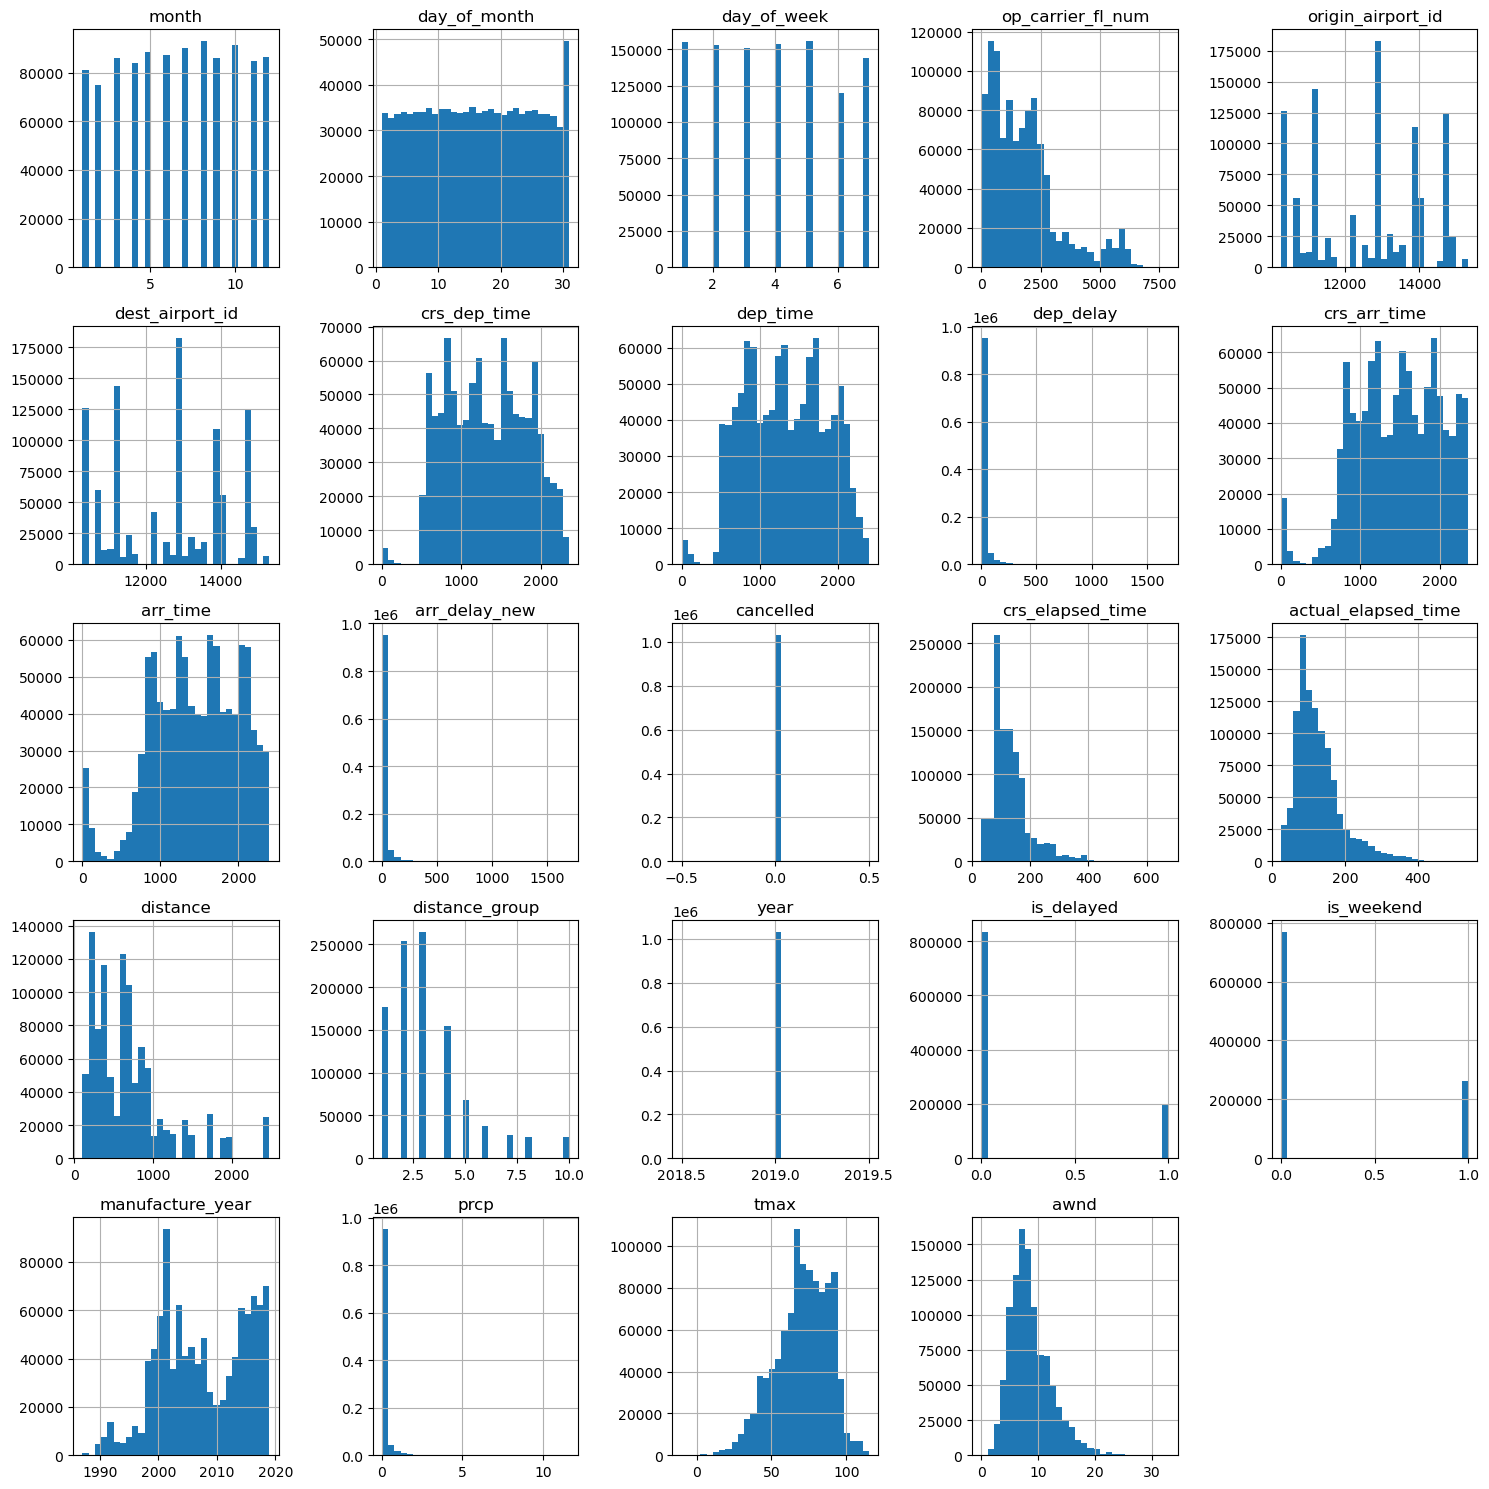

In [28]:
# Wybieramy kolumny numeryczne
num_cols = flight_df.select_dtypes(include=[np.number]).columns

# Tworzymy histogramy - zapoznajemy się z rozkładem danych w kolumnach posiadających wartość numeryczną
flight_df[num_cols].hist(bins=30, figsize=(15, 15))
plt.tight_layout()
plt.show()

In [29]:
print(flight_df.columns)

Index(['month', 'day_of_month', 'day_of_week', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'year', 'is_delayed', 'is_weekend', 'manufacture_year', 'prcp', 'tmax',
       'awnd', 'tmax_group'],
      dtype='object')


W trakcie analizy danych stwierdzono obecność wartości odstających w takich kolumnach jak prcp i dep_delay. Wartości te mogą odzwierciedlać rzeczywiste, istotne zdarzenia, takie jak wyjątkowo wysokie opady lub długie opóźnienia lotów. Dlatego postanowiono zachować te outliery, aby nie stracić kluczowych informacji, które mogą mieć znaczenie dla modelu. Aby skutecznie uwzględnić obecność wartości odstających, wybrano modele odporne na ich wpływ, takie jak drzewa decyzyjne, lasy losowe oraz gradient boosting. Modele te są mniej podatne na wpływ outlierów i mogą samodzielnie określić, które wartości są istotne dla predykcji.

##### TRANSFORMACJA CECH

In [30]:
# Szukamy kolumn, które nie są liczbowe
non_numeric_columns = flight_df.select_dtypes(exclude=['number']).columns

non_numeric_columns

Index(['op_unique_carrier', 'tail_num', 'dep_time_blk', 'arr_time_blk',
       'tmax_group'],
      dtype='object')

In [31]:
# Sprawdzanie liczby unikalnych wartości w każdej nieliczbowej kolumnie
for col in ['op_unique_carrier', 'tail_num', 'dep_time_blk', 'arr_time_blk', 'tmax_group']:
    unique_values = flight_df[col].nunique()
    print(f"Kolumna '{col}' ma {unique_values} unikalnych wartości")


Kolumna 'op_unique_carrier' ma 16 unikalnych wartości
Kolumna 'tail_num' ma 5191 unikalnych wartości
Kolumna 'dep_time_blk' ma 19 unikalnych wartości
Kolumna 'arr_time_blk' ma 19 unikalnych wartości
Kolumna 'tmax_group' ma 24 unikalnych wartości


In [32]:
# One-Hot Encoding dla kolumn z małą ilością unikalnych wartości
flight_df = pd.get_dummies(flight_df, columns=['op_unique_carrier', 'dep_time_blk', 'arr_time_blk'])

# Label Encoding dla kolumny z naturalnym porządkiem
le = LabelEncoder()
flight_df['tmax_group_encoded'] = le.fit_transform(flight_df['tmax_group'])

# Target Encoding dla tail_num
target_enc = ce.TargetEncoder(cols=['tail_num'])
flight_df['tail_num_encoded'] = target_enc.fit_transform(flight_df['tail_num'], flight_df['is_delayed'])

# Usunięcie oryginalnych kolumn, które zostały chwilę temu zakodowane
flight_df.drop(columns=['tmax_group', 'tail_num'], inplace=True)

## TRENOWANIE MODELI

### DRZEWA LOSOWE

In [33]:
# Przygotowujemy zestawy treningowe i testowe
X = flight_df.drop(columns=['is_delayed', 'dep_delay'])  # wszystkie kolumny poza zmiennymi docelowymi)
y_classification = flight_df['is_delayed']  # zmienna docelowa do klasyfikacji
y_regression = flight_df['dep_delay']  # zmienna docelowa do regresji

# Podział na zestawy treningowe i testowe
X_train, X_test, y_train_classification, y_test_classification = train_test_split(X, y_classification, test_size=0.3, random_state=42)
_, _, y_train_regression, y_test_regression = train_test_split(X, y_regression, test_size=0.3, random_state=42)

In [34]:
# Tworzymy i trenujemy model klasyfikacyjny
model_classification = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
model_classification.fit(X_train, y_train_classification)

# Przewidujemy na zbiorze testowym
y_pred_classification = model_classification.predict(X_test)

# Ocena modelu klasyfikacyjnego
accuracy = accuracy_score(y_test_classification, y_pred_classification)
print(f"Dokładność modelu klasyfikacyjnego: {accuracy:.2f}")

Dokładność modelu klasyfikacyjnego: 0.93


In [35]:
# Sprawdzamy dokładność na danych treningowych
train_accuracy = accuracy_score(y_train_classification, model_classification.predict(X_train))
print(f"Dokładność na danych treningowych: {train_accuracy:.2f}")

Dokładność na danych treningowych: 0.93


In [36]:
print(confusion_matrix(y_test_classification, y_pred_classification))
print(classification_report(y_test_classification, y_pred_classification))

[[244233   6015]
 [ 14386  45185]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    250248
           1       0.88      0.76      0.82     59571

    accuracy                           0.93    309819
   macro avg       0.91      0.87      0.89    309819
weighted avg       0.93      0.93      0.93    309819



True Negatives (TN): 244233 - Model poprawnie przewidział brak opóźnienia w 244233 przypadkach.

False Positives (FP): 6015 - Model błędnie przewidział opóźnienie w 6015 przypadkach, mimo że go nie było.

False Negatives (FN): 14386 - Model błędnie przewidział brak opóźnienia w 14386 przypadkach, mimo że opóźnienie wystąpiło.

True Positives (TP): 45185 - Model poprawnie przewidział opóźnienie w 45185 przypadkach.


Recall: 0.76 - Model identyfikuje 76% rzeczywistych opóźnień, co wskazuje na umiarkowaną skuteczność w wykrywaniu opóźnień.

##### W CELU ZNALEZENIA LEPIEJ DOPASOWANEGO MODELU, KORZYSTAMY Z RandomizedSearchCV

In [37]:
# Definiujemy przestrzeń hiperparametrów
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Tworzymy model lasu losowego
rf = RandomForestClassifier(random_state=42)

# Konfigurujemy RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=100,
    cv=5,  # Liczba foldów w cross-validacji
    n_jobs=-1,  # Użycie wszystkich dostępnych rdzeni procesora
    verbose=4,  # Wyświetlanie postępu w konsoli
    scoring='accuracy',
    random_state=42
)

# Przeprowadzamy Random Search na danych treningowych
random_search.fit(X_train, y_train_classification)

# Wyświetlamy najlepsze parametry
print(f"Najlepsze parametry: {random_search.best_params_}")

# Przewidywanie na zbiorze testowym za pomocą najlepszego modelu
best_model_rf = random_search.best_estimator_
y_pred_classification = best_model_rf.predict(X_test)

# Ocena modelu na danych testowych
accuracy = accuracy_score(y_test_classification, y_pred_classification)
print(f"Dokładność modelu klasyfikacyjnego po Random Search: {accuracy:.2f}")

# Zapisanie modelu do pliku
joblib.dump(best_model_rf, 'best_rf_model.pkl')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Najlepsze parametry: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'class_weight': None}
Dokładność modelu klasyfikacyjnego po Random Search: 0.99


['best_rf_model.pkl']

In [49]:
# Dokładność na danych treningowych
train_accuracy = accuracy_score(y_train_classification, random_search.predict(X_train))
print(f"Dokładność na danych treningowych: {train_accuracy:.2f}")

Dokładność na danych treningowych: 1.00


In [39]:
print(confusion_matrix(y_test_classification, y_pred_classification))
print(classification_report(y_test_classification, y_pred_classification))

[[249540    708]
 [  2795  56776]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    250248
           1       0.99      0.95      0.97     59571

    accuracy                           0.99    309819
   macro avg       0.99      0.98      0.98    309819
weighted avg       0.99      0.99      0.99    309819



**Wyniki na danych testowych:**
- **Precision:** 
- Klasa 0 (Brak opóźnienia): 0.99
- Klasa 1 (Opóźnienie): 0.99
- **Recall:** 
- Klasa 0: 1.00
- Klasa 1: 0.95
- **F1-Score:** 
- Klasa 0: 0.99
- Klasa 1: 0.97
- **Accuracy:** 0.99

**Dokładność na danych treningowych:** 1.00

**Interpretacja:**
- Model lasów losowych wykazuje bardzo wysoką skuteczność w przewidywaniu, czy lot będzie opóźniony, czy też nie. Na danych testowych uzyskał dokładność 99%, co świadczy o bardzo dobrej zdolności do generalizacji.
- **Precision** na poziomie 99% dla obu klas oznacza, że model rzadko przewiduje opóźnienia, gdy ich nie ma, oraz że poprawnie identyfikuje przypadki, kiedy opóźnienie rzeczywiście wystąpi.
- **Recall** dla klasy „opóźnienie” wynosi 95%, co oznacza, że model identyfikuje 95% wszystkich opóźnionych lotów, co jest bardzo dobrym wynikiem, choć nieco niższym niż dla klasy „brak opóźnienia” (100%).
- **F1-Score** również jest bardzo wysoki (0.97 dla klasy „opóźnienie”), co świadczy o zrównoważonym stosunku między precyzją a czułością.

### XGBOOST

In [40]:
# Tworzymy model XGBoost
model_xgb = xgb.XGBClassifier(random_state=42)

# Trenujemy model XGBoost na danych treningowych
model_xgb.fit(X_train, y_train_classification)

# Przewidywanie na zbiorze testowym
y_pred_xgb = model_xgb.predict(X_test)

# Ocena modelu
accuracy_xgb = accuracy_score(y_test_classification, y_pred_xgb)
print(f"Dokładność modelu XGBoost: {accuracy_xgb:.2f}")

# Dodatkowe miary
print(classification_report(y_test_classification, y_pred_xgb))

Dokładność modelu XGBoost: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    250248
           1       0.99      0.96      0.98     59571

    accuracy                           0.99    309819
   macro avg       0.99      0.98      0.99    309819
weighted avg       0.99      0.99      0.99    309819



In [47]:
# Dokładność na danych treningowych
train_accuracy = accuracy_score(y_train_classification, model_xgb.predict(X_train))
print(f"Dokładność na danych treningowych: {train_accuracy:.2f}")

Dokładność na danych treningowych: 0.99


In [42]:
print(confusion_matrix(y_test_classification, y_pred_xgb))
print(classification_report(y_test_classification, y_pred_xgb))

[[249566    682]
 [  2121  57450]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    250248
           1       0.99      0.96      0.98     59571

    accuracy                           0.99    309819
   macro avg       0.99      0.98      0.99    309819
weighted avg       0.99      0.99      0.99    309819



##### W CELU ZNALEZENIA LEPIEJ DOPASOWANEGO MODELU, KORZYSTAMY Z GridSearchCV

In [43]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42),
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Uruchomiamy Grid Search na danych treningowych
grid_search_xgb.fit(X_train, y_train_classification)

# Wyświetlamy najlepsze parametry
print(f"Najlepsze parametry dla XGBoost: {grid_search_xgb.best_params_}")

# Przewidujemy na zbiorze testowym za pomocą najlepszego modelu
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Ocena modelu
accuracy_best_xgb = accuracy_score(y_test_classification, y_pred_best_xgb)
print(f"Dokładność najlepszego modelu XGBoost po Grid Search: {accuracy_best_xgb:.2f}")

# Dodatkowe miary
print(classification_report(y_test_classification, y_pred_best_xgb))

# Zapisanie modelu do pliku
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Najlepsze parametry dla XGBoost: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 300, 'subsample': 1.0}
Dokładność najlepszego modelu XGBoost po Grid Search: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    250248
           1       0.99      0.98      0.98     59571

    accuracy                           0.99    309819
   macro avg       0.99      0.99      0.99    309819
weighted avg       0.99      0.99      0.99    309819



['best_xgb_model.pkl']

In [48]:
# Dokładność na danych treningowych
train_accuracy = accuracy_score(y_train_classification, grid_search_xgb.predict(X_train))
print(f"Dokładność na danych treningowych: {train_accuracy:.2f}")

Dokładność na danych treningowych: 1.00


In [45]:
print(confusion_matrix(y_test_classification, y_pred_best_xgb))
print(classification_report(y_test_classification, y_pred_best_xgb))

[[249574    674]
 [  1287  58284]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    250248
           1       0.99      0.98      0.98     59571

    accuracy                           0.99    309819
   macro avg       0.99      0.99      0.99    309819
weighted avg       0.99      0.99      0.99    309819



**Wyniki na danych testowych:**
- **Precision:** 
- Klasa 0 (Brak opóźnienia): 0.99
- Klasa 1 (Opóźnienie): 0.99
- **Recall:** 
- Klasa 0: 1.00
- Klasa 1: 0.98
- **F1-Score:** 
- Klasa 0: 1.00
- Klasa 1: 0.98
- **Accuracy:** 0.99

**Dokładność na danych treningowych:** 1.00

**Interpretacja:**
- Model XGBoost osiągnął również bardzo wysoką skuteczność na danych testowych, z dokładnością wynoszącą 99%, co jest identycznym wynikiem jak w przypadku lasów losowych.
- **Precision** dla obu klas wynosi 99%, co podobnie jak w modelu lasów losowych oznacza, że model rzadko popełnia błędy w przewidywaniu zarówno obecności, jak i braku opóźnienia.
- **Recall** dla klasy „opóźnienie” jest nieco wyższy niż w modelu lasów losowych (98% vs 95%), co oznacza, że XGBoost lepiej identyfikuje opóźnione loty.
- **F1-Score** dla klasy „opóźnienie” wynosi 0.98, co również jest nieco wyższym wynikiem niż w przypadku lasów losowych.

### Podsumowanie i wybór modelu:

Oba modele – Lasy Losowe oraz XGBoost – wykazały się bardzo wysoką skutecznością w identyfikowaniu opóźnień lotów. Oba modele uzyskały dokładność na poziomie 99% na danych testowych oraz idealną dokładność na danych treningowych, co sugeruje, że są one dobrze dopasowane do problemu.

**Model Lasów Losowych** charakteryzuje się bardzo wysoką precyzją i czułością, jednak nieco niższy recall dla klasy „opóźnienie” (95%) może oznaczać, że model nie wychwytuje wszystkich przypadków opóźnień tak skutecznie, jak model XGBoost.

**Model XGBoost** również osiągnął bardzo dobre wyniki, z nieco lepszym recall dla klasy „opóźnienie” (98%), co oznacza, że lepiej identyfikuje opóźnione loty niż model lasów losowych. Ponadto, wyższy F1-Score dla klasy „opóźnienie” sugeruje lepszy balans między precyzją a czułością w identyfikowaniu opóźnień.

**Rekomendacja:** Biorąc pod uwagę wyższy recall i F1-Score dla klasy „opóźnienie” w modelu XGBoost, można go uznać za bardziej odpowiedni model do zastosowania w praktyce. Jego zdolność do skuteczniejszego identyfikowania opóźnionych lotów może być kluczowa w kontekście minimalizacji ryzyka operacyjnego i poprawy zarządzania zasobami w operacjach lotniczych.

## Tworzymy model dla problemu regresji - sprawdzamy, o ile minut może wystąpić opóźnienie

In [46]:
param_dist_regression = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_regressor = RandomForestRegressor(random_state=42)

random_search_regression = RandomizedSearchCV(
    estimator=rf_regressor, 
    param_distributions=param_dist_regression, 
    n_iter=100,
    cv=5,  # Liczba foldów w cross-validacji
    n_jobs=-1,  # Użycie wszystkich dostępnych rdzeni procesora
    verbose=3, 
    scoring='neg_mean_absolute_error',
    random_state=42
)

random_search_regression.fit(X_train, y_train_regression)

best_rf_regressor = random_search_regression.best_estimator_
y_pred_regression = best_rf_regressor.predict(X_test)

# Obliczenie metryk
mae = mean_absolute_error(y_test_regression, y_pred_regression)
mse = mean_squared_error(y_test_regression, y_pred_regression)
r2 = r2_score(y_test_regression, y_pred_regression)

print(f"Najlepsze parametry: {random_search_regression.best_params_}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

joblib.dump(best_rf_regressor, 'best_rf_regressor.pkl')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\damia\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Najlepsze parametry: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None}
Mean Absolute Error: 0.97
Mean Squared Error: 6.02
R^2 Score: 1.00


['best_rf_regressor.pkl']

In [54]:
# Dokładność na danych treningowych

# średni bład kwadratowy
train_mse = mean_squared_error(y_train_regression, random_search_regression.predict(X_train))
print(f"Średni błąd kwadratowy na danych treningowych: {train_mse:.2f}")

# Wspołczynnik determinacji (R²)
train_r2 = r2_score(y_train_regression, random_search_regression.predict(X_train))
print(f"Współczynnik determinacji R² na danych treningowych: {train_r2:.2f}")

# średnia wartość bezwzględna błędów
train_mae = mean_absolute_error(y_train_regression, random_search_regression.predict(X_train))
print(f"Średnia wartość bezwzględna błędów na danych treningowych: {train_mae:.2f}")

Średni błąd kwadratowy na danych treningowych: 2.57
Współczynnik determinacji R² na danych treningowych: 1.00
Średnia wartość bezwzględna błędów na danych treningowych: 0.61


#### Wyniki na danych treningowych:
- **Mean Squared Error (MSE):** 2.57
- **Mean Absolute Error (MAE):** 0.61 minut
- **R² Score:** 1.00

**Interpretacja:**
- Model bardzo dobrze dopasowuje się do danych treningowych, o czym świadczy idealny współczynnik determinacji R² = 1.00 oraz niskie wartości MSE i MAE. Średnia wartość bezwzględna błędów (MAE) wynosząca 0.61 minut sugeruje, że model przewiduje opóźnienia lotów z dużą precyzją, popełniając przeciętnie błąd mniejszy niż jedna minuta.

#### Wyniki na danych testowych:
- **Mean Squared Error (MSE):** 6.02
- **Mean Absolute Error (MAE):** 0.97 minut
- **R² Score:** 1.00

**Interpretacja:**
- Na danych testowych model również wykazuje bardzo dobrą skuteczność, co potwierdza współczynnik determinacji R² = 1.00, wskazujący na doskonałe dopasowanie modelu. MSE na poziomie 6.02 jest wyższe niż na danych treningowych, co jest naturalne, ale nadal wskazuje na dobre przewidywania. MAE wynoszące 0.97 minut oznacza, że średni błąd przewidywań na danych testowych wynosi mniej niż minutę, co potwierdza, że model jest bardzo precyzyjny.

### Podsumowanie:

W projekcie opracowano model mający na celu przewidywanie opóźnień wylotu samolotów w minutach. Na podstawie analizy danych zarówno treningowych, jak i testowych, model wykazuje doskonałe dopasowanie oraz wysoką precyzję w przewidywaniu opóźnień.

- Na danych treningowych model osiągnął współczynnik determinacji R² równy 1.00, co oznacza, że w pełni wyjaśnia on zmienność w danych, a jego średni błąd przewidywań wynosił 0.61 minut (MAE). Niski średni błąd kwadratowy (MSE = 2.57) wskazuje na niewielkie błędy, a zatem model jest bardzo dobrze dopasowany do danych treningowych.

- Na danych testowych model utrzymał równie wysoki poziom dokładności, uzyskując współczynnik R² również równy 1.00, co świadczy o jego doskonałej zdolności do generalizacji. Średni błąd przewidywań wyniósł 0.97 minut (MAE), co nadal jest bardzo niską wartością, wskazując na wysoką precyzję modelu. Chociaż MSE wzrosło do 6.02, jest to naturalne przy przejściu na nowe dane i nadal wskazuje na wysoką jakość modelu.

**Wnioski:**
Model jest wysoce skuteczny w przewidywaniu opóźnień wylotów samolotów i wykazuje bardzo dobrą zdolność do generalizacji, co oznacza, że może być z powodzeniem zastosowany w praktyce do prognozowania opóźnień w różnych scenariuszach operacyjnych. Pomimo idealnego dopasowania modelu na obu zbiorach danych, warto monitorować jego wydajność na nowych, niewidzianych wcześniej danych, aby upewnić się, że jego zdolność do generalizacji pozostaje na wysokim poziomie.

Model ten może znacząco wspomóc operacje lotnicze, pozwalając na wcześniejsze wykrywanie potencjalnych opóźnień i lepsze planowanie zasobów.
